# GDN - Multivariate time series anomaly detection

In [3]:
import numpy as np
import torch, time, math, random
from functools import partial
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Parameter, Linear, BatchNorm1d, ReLU
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from scipy.stats import iqr

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg


## Useful functions

In [10]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Model (From original paper)


In [11]:
def get_batch_edge_index(org_edge_index, batch_num, node_num):
    """ Convert single graph edge_index to batched graph edge_index
    Args:
        org_edge_index: torch.Tensor, shape (2, E)
        batch_num: int, number of graphs in the batch
        node_num: int, number of nodes in a single graph
    Returns:
        batch_edge_index: torch.Tensor, shape (2, E*batch_num)"""
    edge_index = org_edge_index.clone().detach()
    edge_num = org_edge_index.shape[1]
    batch_edge_index = edge_index.repeat(1,batch_num).contiguous()
    for i in range(batch_num):
        batch_edge_index[:, i*edge_num:(i+1)*edge_num] += i*node_num
    return batch_edge_index.long()

class GraphLayer(MessagePassing):
    """ Graph Attention Layer with Edge Embeddings """
    def __init__(self, in_channels, out_channels, heads=1, concat=True,
                 negative_slope=0.2, dropout=0, bias=True, inter_dim=-1,**kwargs):
        """ Args:
            in_channels: int, input feature dimension
            out_channels: int, output feature dimension
            heads: int, number of attention heads
            concat: bool, whether to concatenate multi-head results
            negative_slope: float, LeakyReLU negative slope
            dropout: float, dropout rate on attention weights
            bias: bool, whether to add bias term """
        super(GraphLayer, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.node_dim = 0
        self.__alpha__ = None
        self.lin = Linear(in_channels, heads * out_channels, bias=False)
        self.att_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_j = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_j = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        glorot(self.att_i)
        glorot(self.att_j)
        zeros(self.att_em_i)
        zeros(self.att_em_j)
        zeros(self.bias)

    def forward(self, x, edge_index, embedding, return_attention_weights=False):
        if torch.is_tensor(x):
            x = self.lin(x)
            x = (x, x)
        else:
            x = (self.lin(x[0]), self.lin(x[1]))

        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index,
                                       num_nodes=x[1].size(self.node_dim))
        out = self.propagate(edge_index, x=x, embedding=embedding, edges=edge_index,
                             return_attention_weights=return_attention_weights)
        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
        if self.bias is not None:
            out = out + self.bias
        if return_attention_weights:
            alpha, self.__alpha__ = self.__alpha__, None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_index_i, size_i,
                embedding,
                edges,
                return_attention_weights):

        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)

        if embedding is not None:
            embedding_i, embedding_j = embedding[edge_index_i], embedding[edges[0]]
            embedding_i = embedding_i.unsqueeze(1).repeat(1,self.heads,1)
            embedding_j = embedding_j.unsqueeze(1).repeat(1,self.heads,1)
            key_i = torch.cat((x_i, embedding_i), dim=-1)
            key_j = torch.cat((x_j, embedding_j), dim=-1)
        cat_att_i = torch.cat((self.att_i, self.att_em_i), dim=-1)
        cat_att_j = torch.cat((self.att_j, self.att_em_j), dim=-1)

        alpha = (key_i * cat_att_i).sum(-1) + (key_j * cat_att_j).sum(-1) # alpha: (E, heads)
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = alpha.mean(dim=1)          # (E,)
        alpha = softmax(alpha, edge_index_i)   # (E,)
        alpha = alpha.view(-1, 1, 1)       # (E, 1, 1)

        if return_attention_weights:
            self.__alpha__ = alpha

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)

class OutLayer(nn.Module):
    """ Output MLP Layer """
    def __init__(self, in_num, node_num, layer_num, inter_num = 512):
        super(OutLayer, self).__init__()

        modules = []

        for i in range(layer_num):
            # last layer, output shape:1
            if i == layer_num-1:
                modules.append(nn.Linear( in_num if layer_num == 1 else inter_num, 1))
            else:
                layer_in_num = in_num if i == 0 else inter_num
                modules.append(nn.Linear( layer_in_num, inter_num ))
                modules.append(nn.BatchNorm1d(inter_num))
                modules.append(nn.ReLU())

        self.mlp = nn.ModuleList(modules)

    def forward(self, x):
        out = x

        for mod in self.mlp:
            if isinstance(mod, nn.BatchNorm1d):
                out = out.permute(0,2,1)
                out = mod(out)
                out = out.permute(0,2,1)
            else:
                out = mod(out)

        return out

class GNNLayer(nn.Module):
    def __init__(self, in_channel, out_channel, inter_dim=0, heads=1, node_num=100):
        super(GNNLayer, self).__init__()


        self.gnn = GraphLayer(in_channel, out_channel, inter_dim=inter_dim, heads=heads, concat=False)

        self.bn = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x, edge_index, embedding=None, node_num=0):

        out, (new_edge_index, att_weight) = self.gnn(x, edge_index, embedding, return_attention_weights=True)
        self.att_weight_1 = att_weight
        self.edge_index_1 = new_edge_index
  
        out = self.bn(out)
        
        return self.relu(out)

# ------- Main GDN model -------

class GDN(nn.Module):
    def __init__(self, edge_index_sets, node_num, dim=64, out_layer_inter_dim=256, input_dim=10, out_layer_num=1, topk=20):

        super(GDN, self).__init__()

        self.edge_index_sets = edge_index_sets

        embed_dim = dim
        self.embedding = nn.Embedding(node_num, embed_dim)
        self.bn_outlayer_in = nn.BatchNorm1d(embed_dim)


        edge_set_num = len(edge_index_sets)
        self.gnn_layers = nn.ModuleList([
            GNNLayer(input_dim, dim, inter_dim=dim+embed_dim, heads=1) for i in range(edge_set_num)
        ])


        self.node_embedding = None
        self.topk = topk
        self.learned_graph = None

        self.out_layer = OutLayer(dim*edge_set_num, node_num, out_layer_num, inter_num = out_layer_inter_dim)

        self.cache_edge_index_sets = [None] * edge_set_num
        self.cache_embed_index = None

        self.dp = nn.Dropout(0.2)

        self.init_params()
    
    def init_params(self):
        nn.init.kaiming_uniform_(self.embedding.weight, a=math.sqrt(5))


    def forward(self, data):

        x = data.clone().detach()
        edge_index_sets = self.edge_index_sets

        device = data.device

        batch_num, node_num, all_feature = x.shape
        x = x.view(-1, all_feature).contiguous()


        gcn_outs = []
        for i, edge_index in enumerate(edge_index_sets):
            edge_num = edge_index.shape[1]
            cache_edge_index = self.cache_edge_index_sets[i]

            if cache_edge_index is None or cache_edge_index.shape[1] != edge_num*batch_num:
                self.cache_edge_index_sets[i] = get_batch_edge_index(edge_index, batch_num, node_num).to(device)
            
            all_embeddings = self.embedding(torch.arange(node_num).to(device))

            weights_arr = all_embeddings.detach().clone()
            all_embeddings = all_embeddings.repeat(batch_num, 1)

            weights = weights_arr.view(node_num, -1)

            cos_ji_mat = torch.matmul(weights, weights.T)
            normed_mat = torch.matmul(weights.norm(dim=-1).view(-1,1), weights.norm(dim=-1).view(1,-1))
            cos_ji_mat = cos_ji_mat / normed_mat

            topk_num = self.topk

            topk_indices_ji = torch.topk(cos_ji_mat, topk_num, dim=-1)[1]

            self.learned_graph = topk_indices_ji

            gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)
            gated_j = topk_indices_ji.flatten().unsqueeze(0)
            gated_edge_index = torch.cat((gated_j, gated_i), dim=0)

            batch_gated_edge_index = get_batch_edge_index(gated_edge_index, batch_num, node_num).to(device)
            gcn_out = self.gnn_layers[i](x, batch_gated_edge_index, node_num=node_num*batch_num, embedding=all_embeddings)

            
            gcn_outs.append(gcn_out)

        x = torch.cat(gcn_outs, dim=1)
        x = x.view(batch_num, node_num, -1)


        indexes = torch.arange(0,node_num).to(device)
        out = torch.mul(x, self.embedding(indexes))
        
        out = out.permute(0,2,1)
        out = F.relu(self.bn_outlayer_in(out))
        out = out.permute(0,2,1)

        out = self.dp(out)
        out = self.out_layer(out)
        out = out.view(-1, node_num)
   

        return out
        

### Training / testing

In [12]:
def train(
    model=None,
    save_path='',
    config={},
    train_dataloader=None,
    val_dataloader=None,
    loss_func=nn.MSELoss(reduction='mean')
):
    """ Generic training function for:
      - train_loader: batches of (x, y)
      - val_loader: batches of (x, y)
      Args:
        model: nn.Module, the model to train
        save_path: str, path to save the best model
        config: dict, training configuration
        train_dataloader: DataLoader, training data loader
        val_dataloader: DataLoader, validation data loader (optional)
        loss_func: loss function to use during training
      Returns:
        train_loss_list: list of training losses per batch
    """
    
    # Set random seeds for reproducibility
    seed = config['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Initialize training components
    device = get_device()
    loss_func = loss_func
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=config.get('decay', 0), betas=config.get('beta', (0.9, 0.999)))
    train_loss_list = []
    acu_loss = 0
    min_loss = 1e+8
    epoch = config['epoch']
    early_stop_win = config['early_stop_win']
    stop_improve_count = 0
    model.train()
    dataloader = train_dataloader

    for i_epoch in range(epoch):
        acu_loss = 0.0
        model.train()
        for x, y in dataloader:
            x = x.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()
            out = model(x).float().to(device)
            loss = loss_func(out, y)
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            acu_loss += loss.item()

        print(f"epoch ({i_epoch + 1} / {epoch}) (Loss:{acu_loss / len(dataloader):.8f}, ACU_loss:{acu_loss:.8f})", flush=True)

        # early stopping on val loss
        if val_dataloader is not None:
            val_loss, _ = test(model, val_dataloader)
            if val_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1
            if stop_improve_count >= early_stop_win:
                break
        else:
            if acu_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = acu_loss
    return train_loss_list

def test(model, dataloader, loss_func=nn.MSELoss(reduction='mean')):
    """
    Generic test function for:
      - val_loader: batches of (x, y)
      - test_loader: batches of (x, y, labels)
    Args:
      model: nn.Module, the model to evaluate
      dataloader: DataLoader, data loader for evaluation
      loss_func: loss function to use during evaluation

    Returns:
      avg_loss,
      [pred_list, gt_list]                 for (x, y) loaders
      [pred_list, gt_list, label_list]     for (x, y, labels) loaders
    """
    
    loss_func = loss_func
    device = get_device()

    model.eval()

    all_pred = []
    all_gt = []
    all_labels = None  # created only if labels are present

    total_loss = 0.0
    n_batches = 0

    for batch in dataloader:
        # manage the two cases: (x, y) or (x, y, labels)
        if len(batch) == 2:
            x, y = batch
            labels = None
        elif len(batch) == 3:
            x, y, labels = batch
        else:
            raise ValueError(f"Unexpected batch size {len(batch)} (expected 2 or 3).")

        x = x.float().to(device)
        y = y.float().to(device)
        if labels is not None:
            labels = labels.to(device)

        with torch.no_grad():
            pred = model(x).float().to(device)
            loss = loss_func(pred, y)

        total_loss += loss.item()
        n_batches += 1

        all_pred.append(pred.cpu())
        all_gt.append(y.cpu())
        if labels is not None:
            if all_labels is None:
                all_labels = labels.cpu()
            else:
                all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    # Concatenate all batches
    all_pred = torch.cat(all_pred, dim=0).tolist()
    all_gt   = torch.cat(all_gt,   dim=0).tolist()

    avg_loss = total_loss / n_batches

    if all_labels is not None:
        return avg_loss, [all_pred, all_gt, all_labels.tolist()]
    else:
        return avg_loss, [all_pred, all_gt]

### Anomaly detection functions

In [13]:
def compute_mu_iqr(errors, eps=1e-2):
    """
    Compute per-sensor normalization statistics from the given errors.
    Used for validation (for threshold) AND for test (for normalized anomaly scores).
    """
    mu = np.median(errors, axis=0)
    q75 = np.percentile(errors, 75, axis=0)
    q25 = np.percentile(errors, 25, axis=0)
    iqr = q75 - q25
    iqr = iqr + eps
    return mu, iqr


def compute_normalized_scores(pred, gt, smooth_window=3):
    """
    Normalization as done in the official GDN implementation.
    """
    # Compute test errors
    err = np.abs(pred - gt)            # (T, D)

    # Compute mu_test and iqr_test (IMPORTANT: from TEST errors)
    mu_test, iqr_test = compute_mu_iqr(err)

    # Normalized anomaly per sensor
    a = (err - mu_test) / iqr_test            # (T, D)

    # Max across sensors = global anomaly score
    scores = np.max(a, axis=1)

    # Moving-average smoothing window
    if smooth_window > 1:
        kernel = np.ones(smooth_window) / smooth_window
        scores = np.convolve(scores, kernel, mode='same')

    return scores, err, a

def predict_anomaly_labels(scores, threshold):
    return (scores > threshold).astype(int)

def evaluate_anomaly_detection(scores, labels, threshold):
    """ Evaluate point-wise anomaly detection performance.
    Args:
        scores: list or np.array of float, shape (T,), anomaly scores
        labels: list or np.array of int, shape (T,), point-wise anomaly labels (0/1)
        threshold: float, anomaly score threshold for point-wise anomaly prediction
    Returns:
        metrics: dict, containing TP, FP, FN, TN, precision, recall, f1, auc, threshold
    """
    labels = np.asarray(labels).astype(int)
    y_pred = predict_anomaly_labels(scores, threshold)

    return {
        "TP": sum(1 for i in range(len(labels)) if labels[i] == 1 and y_pred[i] == 1),
        "FP": sum(1 for i in range(len(labels)) if labels[i] == 0 and y_pred[i] == 1),
        "FN": sum(1 for i in range(len(labels)) if labels[i] == 1 and y_pred[i] == 0),
        "TN": sum(1 for i in range(len(labels)) if labels[i] == 0 and y_pred[i] == 0),
        "precision": precision_score(labels, y_pred, zero_division=0),
        "recall": recall_score(labels, y_pred, zero_division=0),
        "f1": f1_score(labels, y_pred, zero_division=0),
        "auc": roc_auc_score(labels, scores),
        "threshold": threshold,
    }

def anomaly_sequences(labels):
    """ Extract contiguous anomaly sequences from point-wise labels.
    Args:
        labels: list or np.array of int, shape (T,), point-wise anomaly labels (0/1)
    Returns:
        anomalies_seq: list of [start_idx, end_idx] for each contiguous anomaly sequence
    """
    labels = np.asarray(labels).astype(int)

    anomalies_seq = []
    in_seq = False
    boundaries = [-1, -1]
    for i in range(len(labels)):
        if labels[i] == 1:
            if not in_seq:
                in_seq = True
                boundaries[0] = i
        else:
            if in_seq:
                in_seq = False
                boundaries[1] = i - 1
                anomalies_seq.append(boundaries.copy())
    
    return anomalies_seq

def evaluate_anomaly_detection_on_sequences(scores, labels, threshold):
    """ Evaluate sequence-wise anomaly detection performance. Fuses point-wise predictions within each anomaly sequence.
    Args:
        scores: list or np.array of float, shape (T,), anomaly scores
        labels: list or np.array of int, shape (T,), point-wise anomaly labels (0/1)
        threshold: float, anomaly score threshold for point-wise anomaly prediction
    Returns:
        metrics: dict, containing TP, FP, FN, TN, precision, recall, f1, auc, threshold
    """
    labels = np.asarray(labels).astype(int)
    y_pred = predict_anomaly_labels(scores, threshold)

    anomalies_seq = anomaly_sequences(labels)
    labels_agg_seq = []
    y_pred_agg_seq = []
    scores_agg_seq = []
    for i in range(len(labels)):
      if labels[i] == 0:
            labels_agg_seq.append(labels[i])
            y_pred_agg_seq.append(y_pred[i])
            scores_agg_seq.append(scores[i])
    for (start, end) in anomalies_seq:
        labels_agg_seq.append(1)
        if np.sum(y_pred[start:end+1]) > 0:
            y_pred_agg_seq.append(1)
        else:
            y_pred_agg_seq.append(0)
        scores_agg_seq.append(np.max(scores[start:end+1]))
        
    return {
        "TP": sum(1 for i in range(len(labels_agg_seq)) if labels_agg_seq[i] == 1 and y_pred_agg_seq[i] == 1),
        "FP": sum(1 for i in range(len(labels_agg_seq)) if labels_agg_seq[i] == 0 and y_pred_agg_seq[i] == 1),
        "FN": sum(1 for i in range(len(labels_agg_seq)) if labels_agg_seq[i] == 1 and y_pred_agg_seq[i] == 0),
        "TN": sum(1 for i in range(len(labels_agg_seq)) if labels_agg_seq[i] == 0 and y_pred_agg_seq[i] == 0),
        "precision": precision_score(labels_agg_seq, y_pred_agg_seq, zero_division=0),
        "recall": recall_score(labels_agg_seq, y_pred_agg_seq, zero_division=0),
        "f1": f1_score(labels_agg_seq, y_pred_agg_seq, zero_division=0),
        "auc": roc_auc_score(labels_agg_seq, scores_agg_seq),
        "threshold": threshold,
    }

### Data manipulation

In [14]:
def create_sliding_windows(data, window_size):
    """
    Creates overlapping sequences (sliding windows) from the time series data.
    Input: (T, D) -> Output: (N_samples, D, Window_Size)
    """
    N_time, _ = data.shape
    windows = []
    # Loop from 0 up to the point where a full window can be created
    for i in range(N_time - window_size):
        windows.append(data[i : i + window_size, :].T) # Transpose to (D, Window_Size) 
    return np.array(windows)

def data_analyze(x, sensor_id=0, window_var=200):
    T = len(x)
    
    # Signal plot
    plt.figure(figsize=(12,3))
    plt.plot(x)
    plt.title(f"Sensor {sensor_id} - Signal (raw)")
    plt.xlabel("Time")
    plt.show()

    # Local variance sliding window
    var_local = []
    for i in range(T - window_var):
        var_local.append(np.var(x[i:i+window_var]))
    var_local = np.array(var_local)
    
    plt.figure(figsize=(12,3))
    plt.plot(var_local)
    plt.title(f"Sensor {sensor_id} - Local variance (window={window_var})")
    plt.xlabel("Time")
    plt.show()
    
    # Autocorrelation function
    lag_acf = acf(x, nlags=200, fft=True)
    
    plt.figure(figsize=(12,3))
    plt.plot(range(len(lag_acf)), lag_acf)
    plt.title(f"Sensor {sensor_id} - Autocorrelation function")
    plt.xlabel("Lag")
    plt.show()
    
    # DFT Spectrum
    freqs = np.fft.rfftfreq(T)
    amp = np.abs(np.fft.rfft(x))

    plt.figure(figsize=(12,3))
    plt.plot(freqs, amp)
    plt.title(f"Sensor {sensor_id} - DFT Spectrum")
    plt.xlabel("Frequency")
    plt.show()

def check_nan_inf(data, name):
    if np.isnan(data).any():
        print(f"Warning: {name} contains NaN values.")
    if np.isinf(data).any():
        print(f"Warning: {name} contains Inf values.")
    if not np.isnan(data).any() and not np.isinf(data).any():
        print(f"{name} contains no NaN or Inf values.")

def basic_statistics(data):
    print(f"Length : {data.shape[0]}")
    print(f"Num of sensors (features): {data.shape[1]}")
    unique_val = {}
    repartition = [0,0]
    nb_continous = 0
    nb_discrete = 0
    for i in range(data.shape[1]):
        unique_vals, count = np.unique(data[:, i], return_counts=True)
        n_unique = len(unique_vals)
        if n_unique <= 2:
            for i in range(n_unique):
                if unique_vals[i] == 0:
                    repartition[0] += count[i]
                else:
                    repartition[1] += count[i]
            nb_discrete += 1
            str_unique = ', '.join(map(str, unique_vals))
            in_unique = False
            for k in unique_val.keys():
                if k == str_unique:
                    unique_val[k] += 1
                    in_unique = True
                    break
            if not in_unique:
                unique_val[str_unique] = 1 
        else:
            nb_continous += 1
    print(f"Number of continuous features: {nb_continous}")
    print(f"Number of discrete features: {nb_discrete}")
    print("Discrete feature value distributions:")
    for k, v in unique_val.items():
        print(f"    Values: [{k}] -> Count: {v} feature(s)")
    print(f"    Repartition of discrete feature values: "
          f"value 0 : {repartition[0]} ({100*repartition[0]/(repartition[0]+repartition[1]):.2f} %), " 
          f"value 1 : {repartition[1]} ({100*repartition[1]/(repartition[0]+repartition[1]):.2f} %)")

def stat_labels(labels):
    n_anomalies = np.sum(labels)
    n_normal = labels.shape[0] - n_anomalies
    print(f"Total number of points: {labels.shape[0]}")
    print(f"Number of normal points: {n_normal} ({100*n_normal/labels.shape[0]:.2f} %)")
    print(f"Number of anomalous points: {n_anomalies} ({100*n_anomalies/labels.shape[0]:.2f} %)")
    ongoing = 0
    nb_anomaly_sequences = 0
    nb_isolated_anomalies = 0
    length_anomaly_sequences = []
    for l in labels:
        if l == 1:
            ongoing += 1
        if l == 0:
            if ongoing > 1:
                nb_anomaly_sequences += 1
                length_anomaly_sequences.append(ongoing)
                ongoing = 0
            elif ongoing == 1:
                nb_isolated_anomalies += 1
                ongoing = 0
    if ongoing > 1:
        nb_anomaly_sequences += 1
    elif ongoing == 1:
        nb_isolated_anomalies += 1
    length_anomaly_sequences = np.array(length_anomaly_sequences)
    print(f"Number of isolated anomalies (length = 1): {nb_isolated_anomalies}")
    print(f"Number of anomaly sequences (length > 1): {nb_anomaly_sequences}")
    if length_anomaly_sequences.size > 0:
        print(f"    Anomaly sequence lengths -- Min: {np.min(length_anomaly_sequences)}, "
              f"    Max: {np.max(length_anomaly_sequences)}, "
              f"    Mean: {np.mean(length_anomaly_sequences):.2f}, "
              f"    Median: {np.median(length_anomaly_sequences)}")
        
def detrend_least_squares(x, order=1):
    """
    Remove polynomial trend
    """
    x = np.asarray(x)
    T = len(x)
    t = np.arange(T)

    # Construct design matrix B = [t^0, t^1, ..., t^order]
    B = np.vstack([t**k for k in range(order + 1)]).T

    # Least-squares fitting to find polynomial coefficients
    alpha_hat, _, _, _ = np.linalg.lstsq(B, x, rcond=None)

    # Trend reconstruction
    x_trend = B @ alpha_hat

    # Detrended signal
    x_detrended = x - x_trend

    return x_detrended, x_trend


# SMAP dataset

In [ ]:
BASE_DIR = './data' 
TRAIN_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_train.npy'
TEST_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test_label.npy'
    
print("--- Loading Raw Data ---")

try: ## Try to load the data files
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e: # If files not found, download the dataset
    print(f"Error: {e}. Download the dataset and place it in the specified directory.")
    from torch_timeseries.dataset import SMAP
    SMAP(root=BASE_DIR)
    print("Dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
    
print("Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test, _ = X_test_raw.shape

--- Loading Raw Data ---
Data Loaded Successfully.


## Data analysis

### Vizualization

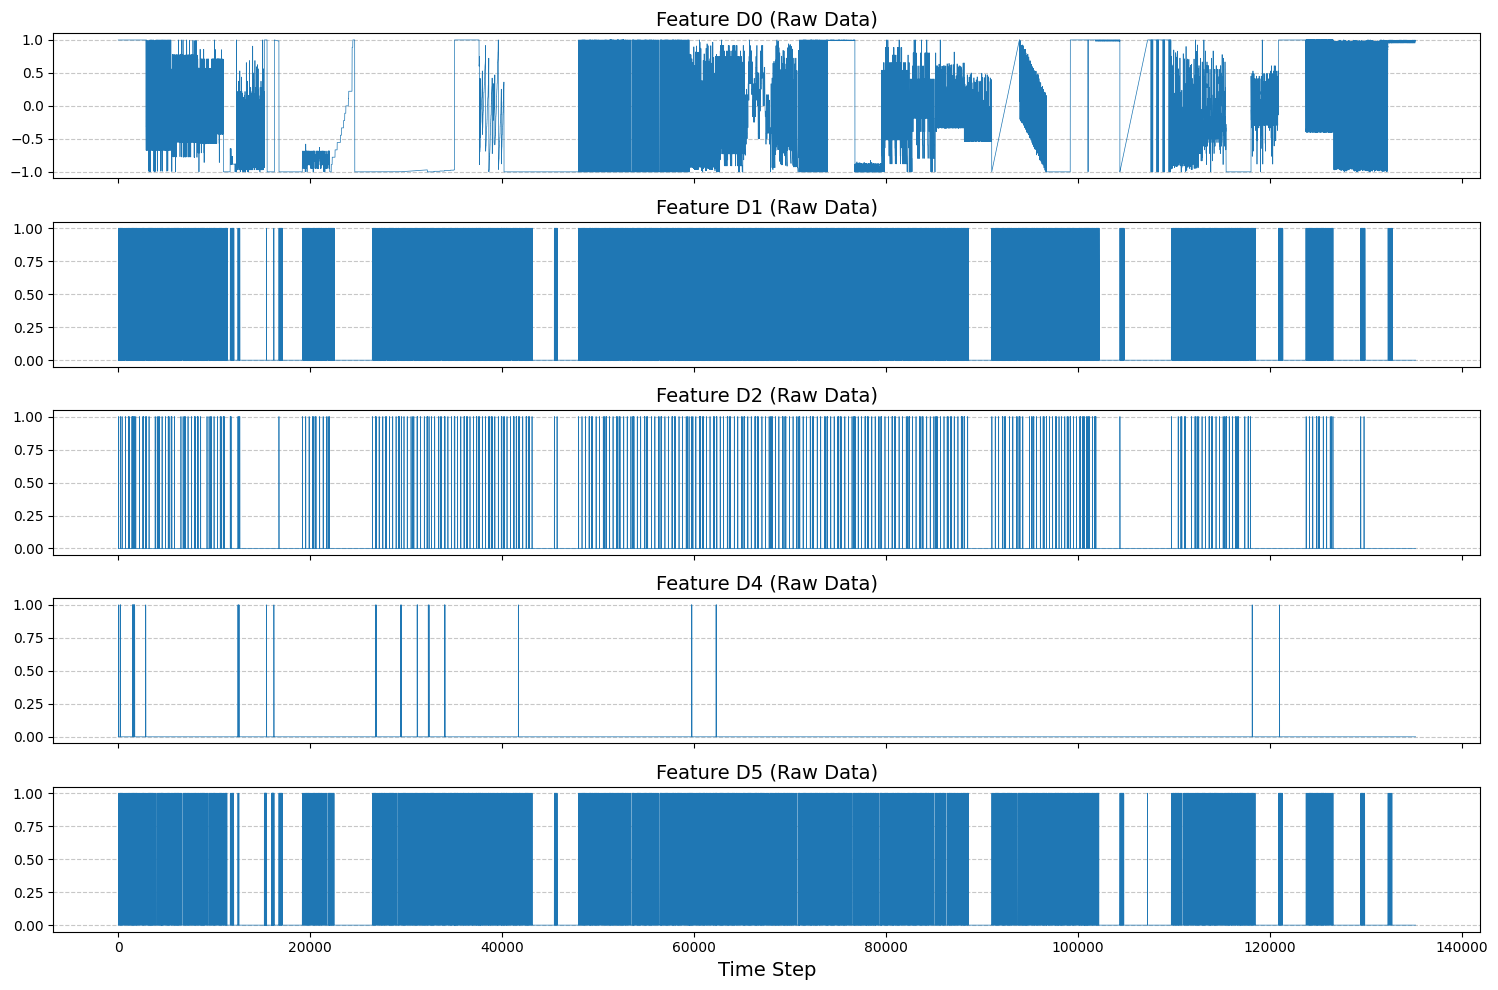

In [ ]:
feature_indices = [0,1,2,4] 
features_to_plot = X_train_raw[:, feature_indices]
time_index = np.arange(T_train)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i, feature_index in enumerate(feature_indices):
    ax = axes[i] 
    ax.plot(
        time_index, 
        features_to_plot[:, i], 
        label=f'Feature D{feature_index}', 
        linewidth=0.5
    )
    # Set title, labels, and grid
    ax.set_title(f'Feature D{feature_index} (Raw Data)', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[3].set_xlabel('Time Step', fontsize=14)
plt.tight_layout()
plt.show()

Plotting the anomaly occurences

/tmp/ipykernel_440171/1927323803.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=12)


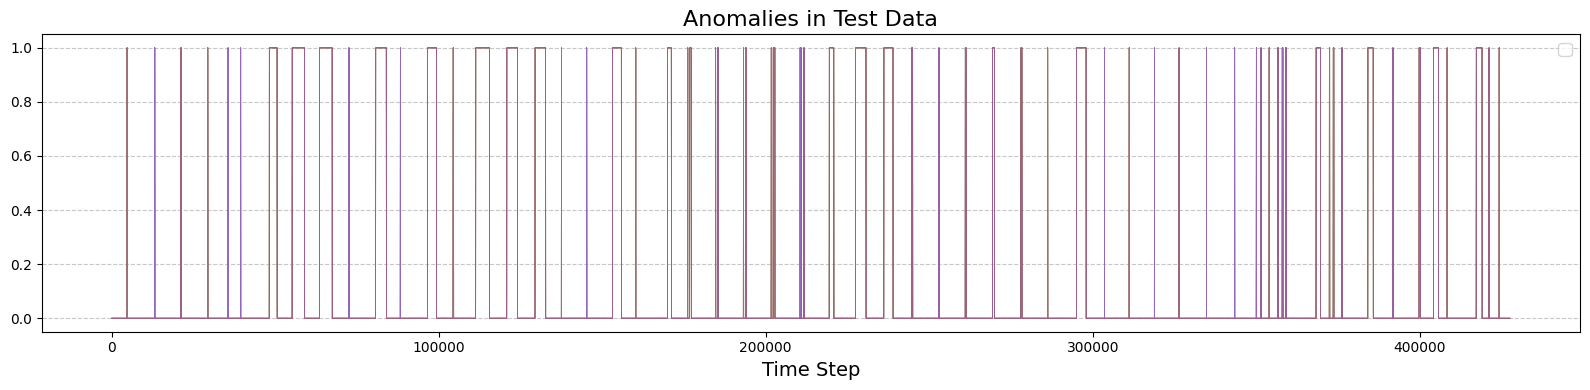

proportion of anomalies: 0.1279 in test set


In [27]:
plt.figure(figsize=(16, 4))
time_index = np.arange(T_test)
# Iterate through the selected features and plot them
for i, feature_index in enumerate(feature_indices):
    plt.plot(
        time_index, 
        y_test_raw,
        linewidth=0.5
    )

plt.title(f'Anomalies in Test Data', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"proportion of anomalies: {np.mean(y_test_raw):.4f} in test set")

### Basic statistics

In [29]:
check_nan_inf(X_train_raw, "X_train_raw")
check_nan_inf(X_test_raw, "X_test_raw")
check_nan_inf(y_test_raw, "y_test_raw")

print("\n--- Basic Statistics for X_train_raw ---")
basic_statistics(X_train_raw)

print("\n--- Basic Statistics for X_test_raw ---")
basic_statistics(X_test_raw)

print("\n--- Basic Statistics for y_test_raw ---")
stat_labels(y_test_raw)

X_train_raw contains no NaN or Inf values.
X_test_raw contains no NaN or Inf values.
y_test_raw contains no NaN or Inf values.

--- Basic Statistics for X_train_raw ---
Length : 135183
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 23 feature(s)
    Values: [0.0] -> Count: 1 feature(s)
    Repartition of discrete feature values: value 0 : 3191110 (98.36 %), value 1 : 53282 (1.64 %)

--- Basic Statistics for X_test_raw ---
Length : 427617
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 24 feature(s)
    Repartition of discrete feature values: value 0 : 10144228 (98.84 %), value 1 : 118580 (1.16 %)

--- Basic Statistics for y_test_raw ---
Total number of points: 427617
Number of normal points: 372921 (87.21 %)
Number of anomalous points: 54696 (12.79 %)
N

### Further analisis for stationarity, noise check

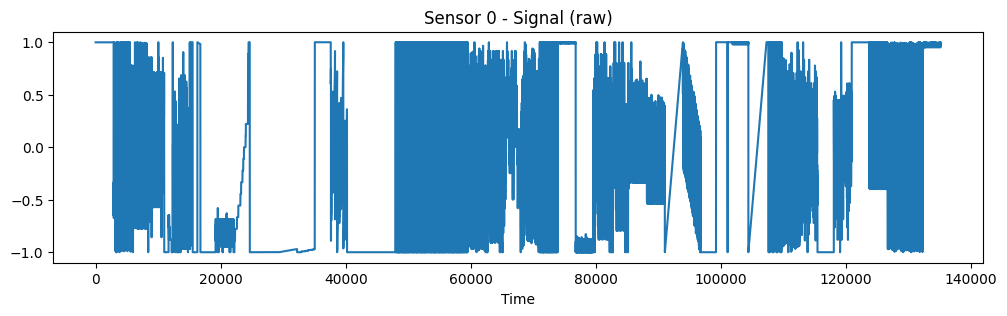

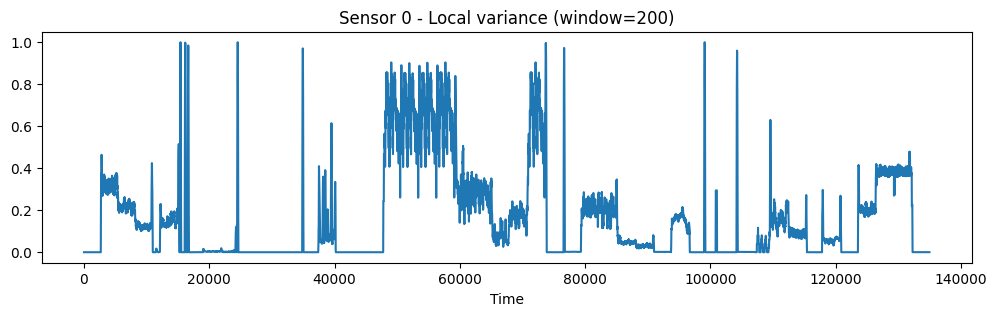

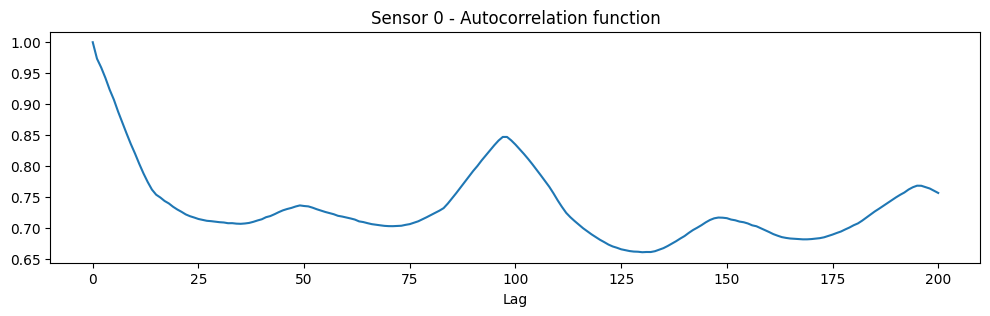

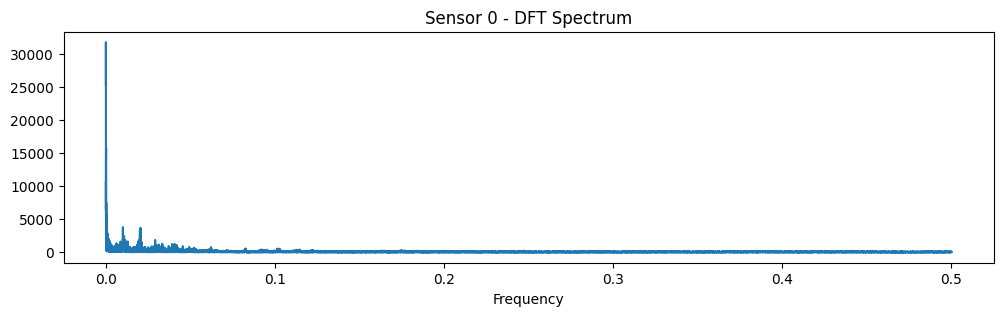

In [ ]:
sensor_id = 0 # We choose the sensor we want to analyze
data_analyze(X_train_raw[:, sensor_id], sensor_id=sensor_id)

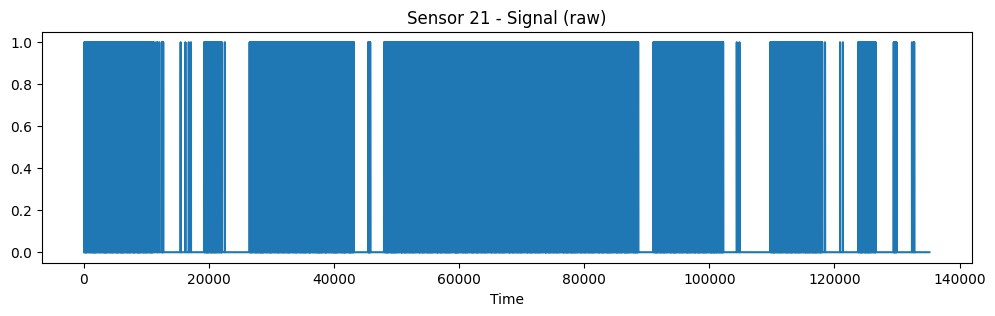

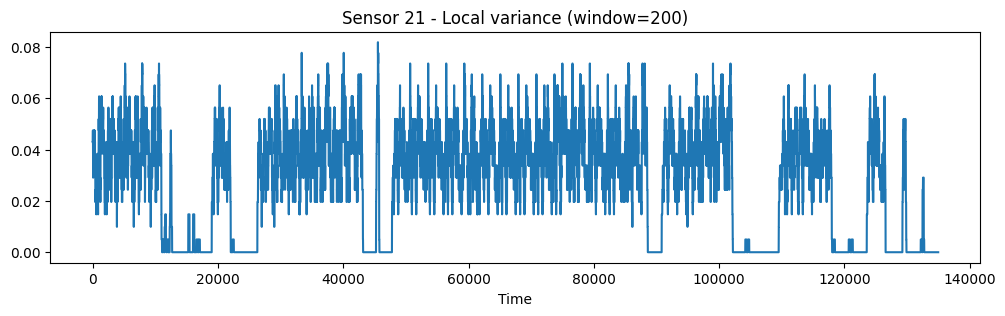

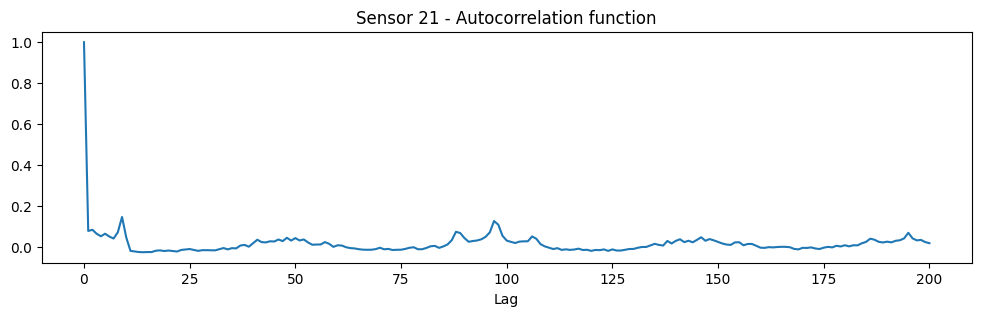

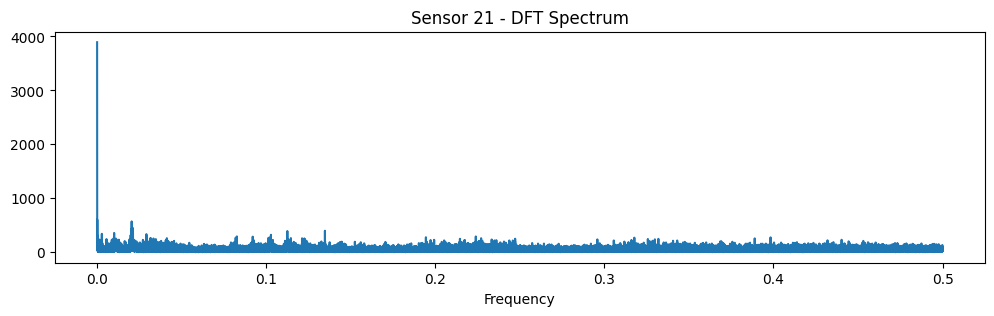

In [ ]:
sensor_id = 21
data_analyze(X_train_raw[:, sensor_id], sensor_id=sensor_id)

### Detrending experimentation

In [34]:
sensor_id = 0   # sensor 0 

# TRAIN
x0_train = X_train_raw[:, sensor_id]
x0_train_detrended, trend_train = detrend_least_squares(x0_train, order=2)

# TEST
x0_test = X_test_raw[:, sensor_id]
x0_test_detrended, trend_test = detrend_least_squares(x0_test, order=2)

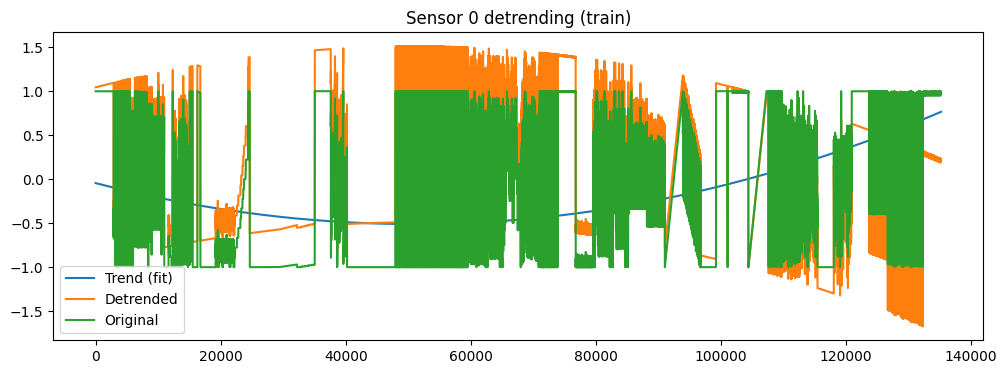

In [35]:
plt.figure(figsize=(12,4))

plt.plot(trend_train, label="Trend (fit)")
plt.plot(x0_train_detrended, label="Detrended")
plt.plot(x0_train, label="Original")
plt.legend()
plt.title("Sensor 0 detrending (train)")
plt.show()

## Baselines

### VAR(100)

In [ ]:
# -----------------------------
# 1) Fit a multivariate VAR(100)
# -----------------------------

val_ratio = 0.2
X_train, X_val = X_train_raw[:int((1 - val_ratio) * T_train)], X_train_raw[int((1 - val_ratio) * T_train):]
X_test = X_test_raw.copy()
labels_test = y_test_raw.copy()

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)
print("Label Test shape:", labels_test.shape)

# Fit VAR on training data
p = 100  # VAR order
print(f"\nFitting VAR({p}) on all {X_train.shape[1]} sensors...")
var_model = VAR(X_train)
var_results = var_model.fit(maxlags=p, ic=None, trend='c')  # fixed lag order
try:
    print(var_results.summary())
except np.linalg.LinAlgError:
    print("Warning: covariance not positive definite, skipping textual summary.")
# Effective order used (should be p)
print("VAR lag order used (k_ar):", var_results.k_ar)

# -----------------------------------------
# 2) One-step-ahead rolling forecast on test
# -----------------------------------------

T_test, _ = X_test.shape
k_ar = var_results.k_ar  # should be 100
print(f"k_ar: {k_ar}")

# Prediction on val
history_val = list(X_val[:k_ar])  # list of length k_ar of vectors (D_features,)
val_pred = []  # will store one-step-ahead predictions for the val set
for t in range(X_val.shape[0]-k_ar):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history_val[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    val_pred.append(y_hat)
    
    # Update history with the *true* val point at time t
    history_val.append(X_val[k_ar+t])
val_pred = np.array(val_pred) # shape (T_val-k_ar, D_features)
val_true = X_val[k_ar:]  # true values from time k_ar to T_val-1

# Prediction on test
history = list(X_test[:k_ar])  # list of length k_ar of vectors (D_features,)
test_pred = []  # will store one-step-ahead predictions for the test set
for t in range(T_test-k_ar):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    test_pred.append(y_hat)
    
    # Update history with the *true* test point at time t
    history.append(X_test[k_ar+t])

test_pred = np.array(test_pred) # shape (T_test-k_ar, D_features)
test_true = X_test[k_ar:]  # true values from time k_ar to T_test-1
labels_true = labels_test[k_ar:]  # true labels from time k_ar to T_test-1

print("\nForecast shapes:")
print("val_pred:", val_pred.shape)
print("val_true:", val_true.shape)
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# 3) Compute errors and anomaly scores
# --------------------------------------

val_scores, val_err, val_a = compute_normalized_scores(val_pred, val_true, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(test_pred, test_true, smooth_window=3)

In [ ]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_true, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


### AR(100)

In [ ]:
# -----------------------------
# 1) Paramètres
# -----------------------------
sensor_idx = 0           # on ne travaille que sur le sensor 0
p = 100          # ordre du modèle AR, ex. 100

val_ratio = 0.2
X_train, X_val = X_train_raw[:int((1 - val_ratio) * T_train),sensor_idx], X_train_raw[int((1 - val_ratio) * T_train):,sensor_idx]
X_test = X_test_raw[:, sensor_idx].copy()
labels_test = y_test_raw.copy()

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)
print("Label Test shape:", labels_test.shape)

# -----------------------------
# Fit AR(p) sur le train
# -----------------------------
ar_model = AutoReg(X_train, lags=p, old_names=False).fit()
print(ar_model.summary())

# Coefficients : x_t = const + sum_{k=1}^p phi_k * x_{t-k}
const = ar_model.params[0]
phi   = ar_model.params[1:]   # shape (p,)

print("AR order       :", len(phi))
print("Const          :", const)

# Prédiction sur le jeu de validation
history_val = list(X_val[:p])
val_pred = []
for t in range(X_val.shape[0]-p):
    past = np.array(history_val[-p:])   # shape (p,)
    lags = past[::-1]    # [x_{t-1}, ..., x_{t-p}]
    y_hat = const + np.dot(phi, lags)

    val_pred.append(y_hat)
    history_val.append(X_val[p+t])
    
val_pred = np.array(val_pred)
val_true = X_val[p:]

# Prédiction sur le jeu de test
history = list(X_test[:p])
test_pred = []
for t in range(T_test-p):
    past = np.array(history[-p:])   # shape (p,)
    lags = past[::-1]    # [x_{t-1}, ..., x_{t-p}]
    y_hat = const + np.dot(phi, lags)

    test_pred.append(y_hat)
    history.append(X_test[p+t])

test_pred = np.array(test_pred)
test_true = X_test[p:]
labels_true = labels_test[p:]

print("\nForecast shapes:")
print("val_pred:", val_pred.shape)
print("val_true:", val_true.shape)
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# Compute errors and anomaly scores
# --------------------------------------
# Absolute error per sensor ( PAS DE NORMALISATION ??)
val_scores, val_err, val_a = compute_normalized_scores(val_pred, val_true, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(test_pred, test_true, smooth_window=3)

In [ ]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_true, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Experiment #1 : Basic replication

In [ ]:
# Experiment configuration
config = {
    'window_size':5,
    'prediction_horizon':1,
    'val_ratio':0.2,
    'seed': 42,
    'batch_size':64,
    'embedding_dim':64,
    'decay': 0,
    'epoch': 50,
    'early_stop_win': 10,
    'beta': (0.9, 0.999)
}
config['save_path'] = "./model_normal/gdn_smap_w_"+str(config['window_size'])+"_epoch"+str(config['epoch'])+".pth"

In [37]:
# Split training data into training and validation sets
X_train, X_val = np.split(X_train_raw, [int((1 - config['val_ratio']) * len(X_train_raw))])

# --- Sliding Window Creation ---
X_train_windows = create_sliding_windows(X_train, config['window_size'])
y_train_windows = X_train[config['window_size']:, :]
X_val_windows = create_sliding_windows(X_val, config['window_size'])
y_val_windows = X_val[config['window_size']:, :]
X_test_windows = create_sliding_windows(X_test_raw, config['window_size'])
y_test_windows = X_test_raw[config['window_size']:, :]
labels_test_windows = y_test_raw[config['window_size']:]

# Shape inspection
print("--- Sliding Window Creation ---")
print(f"X_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_val_windows shape: {X_val_windows.shape}")
print(f"y_val_windows shape: {y_val_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"labels_test_windows shape: {labels_test_windows.shape}")

# --- DataLoader Creation ---
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)
X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)
X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
label_test_tensor = torch.from_numpy(labels_test_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")


--- Sliding Window Creation ---
X_train_windows shape: (108141, 25, 5)
y_train_windows shape: (108141, 25)
X_val_windows shape: (27032, 25, 5)
y_val_windows shape: (27032, 25)
X_test_windows shape: (427612, 25, 5)
y_test_windows shape: (427612, 25)
labels_test_windows shape: (427612,)

--- DataLoader Creation Complete ---
Number of training batches: 3380
Number of validation batches: 845
Number of testing batches: 13363
Data is ready for the GDN model training.


### Training

In [ ]:
device = get_device()

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters
model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=D_features,
    dim=config['embedding_dim'],                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=config.get('out_layer_inter_dim', 64), # | original GDN: 64 or 128
    input_dim=config['window_size'],    # temporal window size | original GDN: 5
    out_layer_num=config.get('out_layer_num', 1),  # number of MLP layers in output layer | original GDN: 1
    topk=config.get('topk', 15)             # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)



edge_index shape: torch.Size([2, 600])


In [ ]:
train_losses = train(
    model=model,
    save_path=config['save_path'],
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader
)
print("Training finished. Best model saved to:", config['save_path'])

epoch (1 / 50) (Loss:0.01878693, ACU_loss:31.74991115)
epoch (2 / 50) (Loss:0.01369202, ACU_loss:23.13951914)
epoch (3 / 50) (Loss:0.01315616, ACU_loss:22.23391619)
epoch (4 / 50) (Loss:0.01286634, ACU_loss:21.74410617)
epoch (5 / 50) (Loss:0.01266912, ACU_loss:21.41081299)
epoch (6 / 50) (Loss:0.01256085, ACU_loss:21.22783270)
epoch (7 / 50) (Loss:0.01243776, ACU_loss:21.01981584)
epoch (8 / 50) (Loss:0.01233232, ACU_loss:20.84162105)
epoch (9 / 50) (Loss:0.01229394, ACU_loss:20.77675728)
epoch (10 / 50) (Loss:0.01218851, ACU_loss:20.59857673)
epoch (11 / 50) (Loss:0.01212970, ACU_loss:20.49919270)
epoch (12 / 50) (Loss:0.01209799, ACU_loss:20.44560550)
epoch (13 / 50) (Loss:0.01206206, ACU_loss:20.38487598)
epoch (14 / 50) (Loss:0.01203516, ACU_loss:20.33942537)
epoch (15 / 50) (Loss:0.01201668, ACU_loss:20.30818618)
epoch (16 / 50) (Loss:0.01199862, ACU_loss:20.27766409)
epoch (17 / 50) (Loss:0.01197795, ACU_loss:20.24273109)
epoch (18 / 50) (Loss:0.01194967, ACU_loss:20.19495075)
e

### Evaluation

In [51]:
# If you want to load the best model later, uncomment the following line:
# model.load_state_dict(torch.load(config['save_path'], map_location=device))

# --- Evaluation on Validation and Test Sets ---
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

# Compute normalized anomaly scores
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

Validation Loss: 0.009338
Test Loss: 0.007966


In [52]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Experiment #2 : Adapting model outputs and train loss

In [2]:
def mixed_loss(y_pred, y_true, lambda_cont=1.0, lambda_bin=24):
    # y_pred, y_true : (batch_size, 25)
    y_cont_pred = y_pred[:, 0]      # continuous sensor
    y_cont_true = y_true[:, 0]

    y_bin_pred = y_pred[:, 1:]      # logits for binary sensors
    y_bin_true = y_true[:, 1:].float()

    # 1) continuous: MSE
    loss_cont = F.mse_loss(y_cont_pred, y_cont_true)

    # 2) binary: BCEWithLogits
    loss_bin = F.binary_cross_entropy_with_logits(y_bin_pred, y_bin_true)

    return lambda_cont * loss_cont + lambda_bin * loss_bin

In [ ]:
# Experiment configuration
config = {
    'window_size':100,
    'prediction_horizon':1,
    'val_ratio':0.2,
    'seed': 42,
    'batch_size':64,
    'embedding_dim':64,
    'decay': 0,
    'epoch': 50,
    'early_stop_win': 10,
    'beta': (0.9, 0.999)
}
config['save_path'] = "./model_mixed/gdn_smap_w_"+str(config['window_size'])+"_epoch"+str(config['epoch'])+".pth"

In [5]:
# Split training data into training and validation sets
X_train, X_val = np.split(X_train_raw, [int((1 - config['val_ratio']) * len(X_train_raw))])

# --- Sliding Window Creation ---
X_train_windows = create_sliding_windows(X_train, config['window_size'])
y_train_windows = X_train[config['window_size']:, :]
X_val_windows = create_sliding_windows(X_val, config['window_size'])
y_val_windows = X_val[config['window_size']:, :]
X_test_windows = create_sliding_windows(X_test_raw, config['window_size'])
y_test_windows = X_test_raw[config['window_size']:, :]
labels_test_windows = y_test_raw[config['window_size']:]

# Shape inspection
print("--- Sliding Window Creation ---")
print(f"X_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_val_windows shape: {X_val_windows.shape}")
print(f"y_val_windows shape: {y_val_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"labels_test_windows shape: {labels_test_windows.shape}")

# --- DataLoader Creation ---
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)
X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)
X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
label_test_tensor = torch.from_numpy(labels_test_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")

NameError: name 'X_train_raw' is not defined

### Training

In [ ]:
device = get_device()

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters
model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=D_features,
    dim=config['embedding_dim'],                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=config.get('out_layer_inter_dim', 64), # | original GDN: 64 or 128
    input_dim=config['window_size'],    # temporal window size | original GDN: 5
    out_layer_num=config.get('out_layer_num', 1),  # number of MLP layers in output layer | original GDN: 1
    topk=config.get('topk', 15)             # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)

edge_index shape: torch.Size([2, 600])


In [ ]:
train_losses = train(
    model=model,
    save_path=config['save_path'],
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_func=partial(mixed_loss, lambda_cont=1.0, lambda_bin=24)
)
print("Training finished. Best model saved to:", config['save_path'])

epoch (1 / 50) (Loss:0.01878693, ACU_loss:31.74991115)
epoch (2 / 50) (Loss:0.01369202, ACU_loss:23.13951914)
epoch (3 / 50) (Loss:0.01315616, ACU_loss:22.23391619)
epoch (4 / 50) (Loss:0.01286634, ACU_loss:21.74410617)
epoch (5 / 50) (Loss:0.01266912, ACU_loss:21.41081299)
epoch (6 / 50) (Loss:0.01256085, ACU_loss:21.22783270)
epoch (7 / 50) (Loss:0.01243776, ACU_loss:21.01981584)
epoch (8 / 50) (Loss:0.01233232, ACU_loss:20.84162105)
epoch (9 / 50) (Loss:0.01229394, ACU_loss:20.77675728)
epoch (10 / 50) (Loss:0.01218851, ACU_loss:20.59857673)
epoch (11 / 50) (Loss:0.01212970, ACU_loss:20.49919270)
epoch (12 / 50) (Loss:0.01209799, ACU_loss:20.44560550)
epoch (13 / 50) (Loss:0.01206206, ACU_loss:20.38487598)
epoch (14 / 50) (Loss:0.01203516, ACU_loss:20.33942537)
epoch (15 / 50) (Loss:0.01201668, ACU_loss:20.30818618)
epoch (16 / 50) (Loss:0.01199862, ACU_loss:20.27766409)
epoch (17 / 50) (Loss:0.01197795, ACU_loss:20.24273109)
epoch (18 / 50) (Loss:0.01194967, ACU_loss:20.19495075)
e

### Evaluation

In [ ]:
# If you want to load the best model later, uncomment the following line:
# model.load_state_dict(torch.load(config['save_path'], map_location=device))

# --- Evaluation on Validation and Test Sets ---
val_loss, val_result = test(model, val_loader, loss_func=partial(mixed_loss, lambda_cont=1.0, lambda_bin=24))
test_loss, test_result = test(model, test_loader, loss_func=partial(mixed_loss, lambda_cont=1.0, lambda_bin=24) )
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

# Compute normalized anomaly scores
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

Validation Loss: 0.009338
Test Loss: 0.007966


In [ ]:
## Threshold selection based on validation set

threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Experiments #3 : Anomaly in the train set

In [ ]:
# Configuration Parameters
config = {
    'seed': 42,
    'window_size': 5,
    'prediction_horizon': 1,
    'val_ratio': 0.2,
    'epoch': 50,
    'early_stop_win': 10,
    'batch_size': 32,
    'decay': 0,
    'beta': (0.9, 0.999),
    'emb_dim': 64,                 # embedding dimension | original GDN: 64 or 128
    'out_layer_inter_dim': 64,  # | original GDN: 64 or 128
    'out_layer_num': 1,          # number of layers in output MLP | original GDN: 1 or 2
    'topk': 15           # number of neighbors to keep in learned graph
}
config['save_path'] = "./model_normal/gdn_smap"+str(config['epoch'])+".pth"

### Data pre-processing

In [ ]:
# Split training data into training and validation sets
X_train, X_test = np.split(X_test_raw, [int(0.33 * len(X_test_raw))])
lambda_test = y_test_raw[int(0.33 * len(y_test_raw)):]
X_train, X_val = np.split(X_train, [int((1 - config['val_ratio']) * len(X_train))])

# --- Sliding Window Creation ---
X_train_windows = create_sliding_windows(X_train, config['window_size'])
y_train_windows = X_train[config['window_size']:, :]
X_val_windows = create_sliding_windows(X_val, config['window_size'])
y_val_windows = X_val[config['window_size']:, :]
X_test_windows = create_sliding_windows(X_test, config['window_size'])
y_test_windows = X_test[config['window_size']:, :]
labels_test_windows = lambda_test[config['window_size']:]

# Shape inspection
print("--- Sliding Window Creation ---")
print(f"X_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_val_windows shape: {X_val_windows.shape}")
print(f"y_val_windows shape: {y_val_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"labels_test_windows shape: {labels_test_windows.shape}")

# --- DataLoader Creation ---
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)
X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)
X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
label_test_tensor = torch.from_numpy(labels_test_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")

--- Sliding Window Creation ---
X_train_windows shape: (112885, 25, 5)
y_train_windows shape: (112885, 25)
X_val_windows shape: (28218, 25, 5)
y_val_windows shape: (28218, 25)
X_test_windows shape: (286499, 25, 5)
y_test_windows shape: (286499, 25)
labels_test_windows shape: (286499,)

--- DataLoader Creation Complete ---
Number of training batches: 3528
Number of validation batches: 882
Number of testing batches: 8954
Data is ready for the GDN model training.


### Training

In [ ]:
device = get_device()

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters
model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=D_features,
    dim=config['emb_dim'],                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=config['out_layer_inter_dim'], # | original GDN: 64 or 128
    input_dim=config['window_size'],    # temporal window size | original GDN: 5
    out_layer_num=config['out_layer_num'],
    topk=config['topk']               # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)

edge_index shape: torch.Size([2, 600])


In [ ]:
train_losses = train(
    model=model,
    save_path=config['save_path'],
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader
)

print("Training finished. Best model saved to:", config['save_path'])

epoch (1 / 50) (Loss:0.01803017, ACU_loss:30.47098287)
epoch (2 / 50) (Loss:0.01409969, ACU_loss:23.82848359)
epoch (3 / 50) (Loss:0.01303221, ACU_loss:22.02444052)
epoch (4 / 50) (Loss:0.01250595, ACU_loss:21.13506191)
epoch (5 / 50) (Loss:0.01189087, ACU_loss:20.09556868)
epoch (6 / 50) (Loss:0.01165523, ACU_loss:19.69734485)
epoch (7 / 50) (Loss:0.01258677, ACU_loss:21.27164593)
epoch (8 / 50) (Loss:0.01225753, ACU_loss:20.71522350)
epoch (9 / 50) (Loss:0.01211570, ACU_loss:20.47553576)
epoch (10 / 50) (Loss:0.01198231, ACU_loss:20.25009648)
epoch (11 / 50) (Loss:0.01161842, ACU_loss:19.63513365)
epoch (12 / 50) (Loss:0.01178156, ACU_loss:19.91083773)
epoch (13 / 50) (Loss:0.01225998, ACU_loss:20.71936494)
epoch (14 / 50) (Loss:0.01204002, ACU_loss:20.34763990)
epoch (15 / 50) (Loss:0.01199171, ACU_loss:20.26599451)
epoch (16 / 50) (Loss:0.01196057, ACU_loss:20.21336111)
epoch (17 / 50) (Loss:0.01199139, ACU_loss:20.26544957)
epoch (18 / 50) (Loss:0.01200623, ACU_loss:20.29052137)
e

### Evaluation

In [ ]:
# If you want to load the best model later, uncomment the following line:
# model.load_state_dict(torch.load(config['save_path'], map_location=device))

# --- Evaluation on Validation and Test Sets ---
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

# Compute normalized anomaly scores
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

In [ ]:
## Threshold selection based on validation set

threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Expermient #4 : Changing window size

In [ ]:
# Configuration Parameters
config = {
    'seed': 42,
    'prediction_horizon': 1,
    'val_ratio': 0.2,
    'epoch': 50,
    'early_stop_win': 10,
    'batch_size': 32,
    'decay': 0,
    'beta': (0.9, 0.999),
    'emb_dim': 64,                 # embedding dimension | original GDN: 64 or 128
    'out_layer_inter_dim': 64,  # | original GDN: 64 or 128
    'out_layer_num': 1,          # number of layers in output MLP | original GDN: 1 or 2
    'topk': 15           # number of neighbors to keep in learned graph
}

window_list = [5, 10, 20, 50, 75, 100, 150, 200]

### Training

In [ ]:
device = get_device()

# Split training data into training and validation sets
X_train, X_val = np.split(X_train_raw, [int((1 - config['val_ratio']) * len(X_train_raw))])

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

AUC_per_W = {}

for W in window_list:
    config['window_size'] = W
    config['save_path'] = "./model_normal/gdn_smap_w"+str(W)+"_epochs_"+str(config['epoch'])+".pth"
    
    # --- Sliding Window Creation ---
    X_train_windows = create_sliding_windows(X_train, config['window_size'])
    y_train_windows = X_train[config['window_size']:, :]
    X_val_windows = create_sliding_windows(X_val, config['window_size'])
    y_val_windows = X_val[config['window_size']:, :]
    X_test_windows = create_sliding_windows(X_test_raw, config['window_size'])
    y_test_windows = X_test_raw[config['window_size']:, :]
    labels_test_windows = y_test_raw[config['window_size']:]

    X_train_tensor = torch.from_numpy(X_train_windows)
    y_train_tensor = torch.from_numpy(y_train_windows)
    X_val_tensor = torch.from_numpy(X_val_windows)
    y_val_tensor = torch.from_numpy(y_val_windows)
    X_test_tensor = torch.from_numpy(X_test_windows)
    y_test_tensor = torch.from_numpy(y_test_windows)
    label_test_tensor = torch.from_numpy(labels_test_windows)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    model = GDN(
        edge_index_sets=edge_index_sets,
        node_num=D_features,
        dim=config['embedding_dim'],                 # embedding dimension | original GDN: 64 or 128
        out_layer_inter_dim=config.get('out_layer_inter_dim', 64), # | original GDN: 64 or 128
        input_dim=config['window_size'],    # temporal window size | original GDN: 5
        out_layer_num=config.get('out_layer_num', 1),  # number of MLP layers in output layer | original GDN: 1
        topk=config.get('topk', 15)             # number of neighbors to keep in learned graph | original GDN: 15 or 30
    ).to(device)
    train_losses = train(
        model=model,
        save_path=config['save_path'],
        config=config,
        train_dataloader=train_loader,
        val_dataloader=val_loader
    )
    print("Training finished. Best model saved to:", config['save_path'])
    
    # --- Evaluation on Validation and Test Sets ---
    val_loss, val_result = test(model, val_loader)
    test_loss, test_result = test(model, test_loader)
    print(f"Validation Loss: {val_loss:.6f}")
    print(f"Test Loss: {test_loss:.6f}")

    pred_val, gt_val = val_result
    pred_test, gt_test, labels_test = test_result

    pred_val = np.array(pred_val)
    gt_val = np.array(gt_val)
    pred_test = np.array(pred_test)
    gt_test = np.array(gt_test)
    labels_test = np.array(labels_test)

    # Compute normalized anomaly scores
    val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
    test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)
    threshold = np.max(val_scores) # threshold for anomaly detection

    # Strict point-wise evaluation
    strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
    AUC_per_W[W] = strict_metrics['auc']

### Plot

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(AUC_per_W.keys()), list(AUC_per_W.values()), marker='o', linewidth=2)
plt.xlabel("Window Size (w)", fontsize=12)
plt.ylabel("point-wise AUC", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(list(AUC_per_W.keys()))
plt.tight_layout()
plt.show()

# SMD dataset

In [4]:
# -----------------------------
# 1. Configuration and File Paths (SMD)
# -----------------------------
BASE_DIR = './data'
TRAIN_DATA_PATH = BASE_DIR + '/SMD/SMD/SMD_train.npy'
TEST_DATA_PATH  = BASE_DIR + '/SMD/SMD/SMD_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMD/SMD/SMD_test_label.npy'

print("--- Loading SMD Raw Data ---")
try:
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}. Downloading SMD dataset via torch_timeseries...")
    from torch_timeseries.dataset import SMD
    SMD(root=BASE_DIR)
    print("SMD dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)

print("SMD Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test,  _         = X_test_raw.shape
print(f"SMD train shape: {X_train_raw.shape}")
print(f"SMD test  shape: {X_test_raw.shape}")
print(f"SMD labels shape: {y_test_raw.shape}")


--- Loading SMD Raw Data ---
Error: [Errno 2] No such file or directory: './data/SMD/SMD/SMD_train.npy'. Downloading SMD dataset via torch_timeseries...


100%|██████████| 194846195/194846195 [00:23<00:00, 8364897.98it/s] 


Extracting ./data/SMD/SMD.zip to ./data/SMD
SMD dataset downloaded.
SMD Data Loaded Successfully.
SMD train shape: (708405, 38)
SMD test  shape: (708420, 38)
SMD labels shape: (708420,)


## Data analysis

### Vizualization

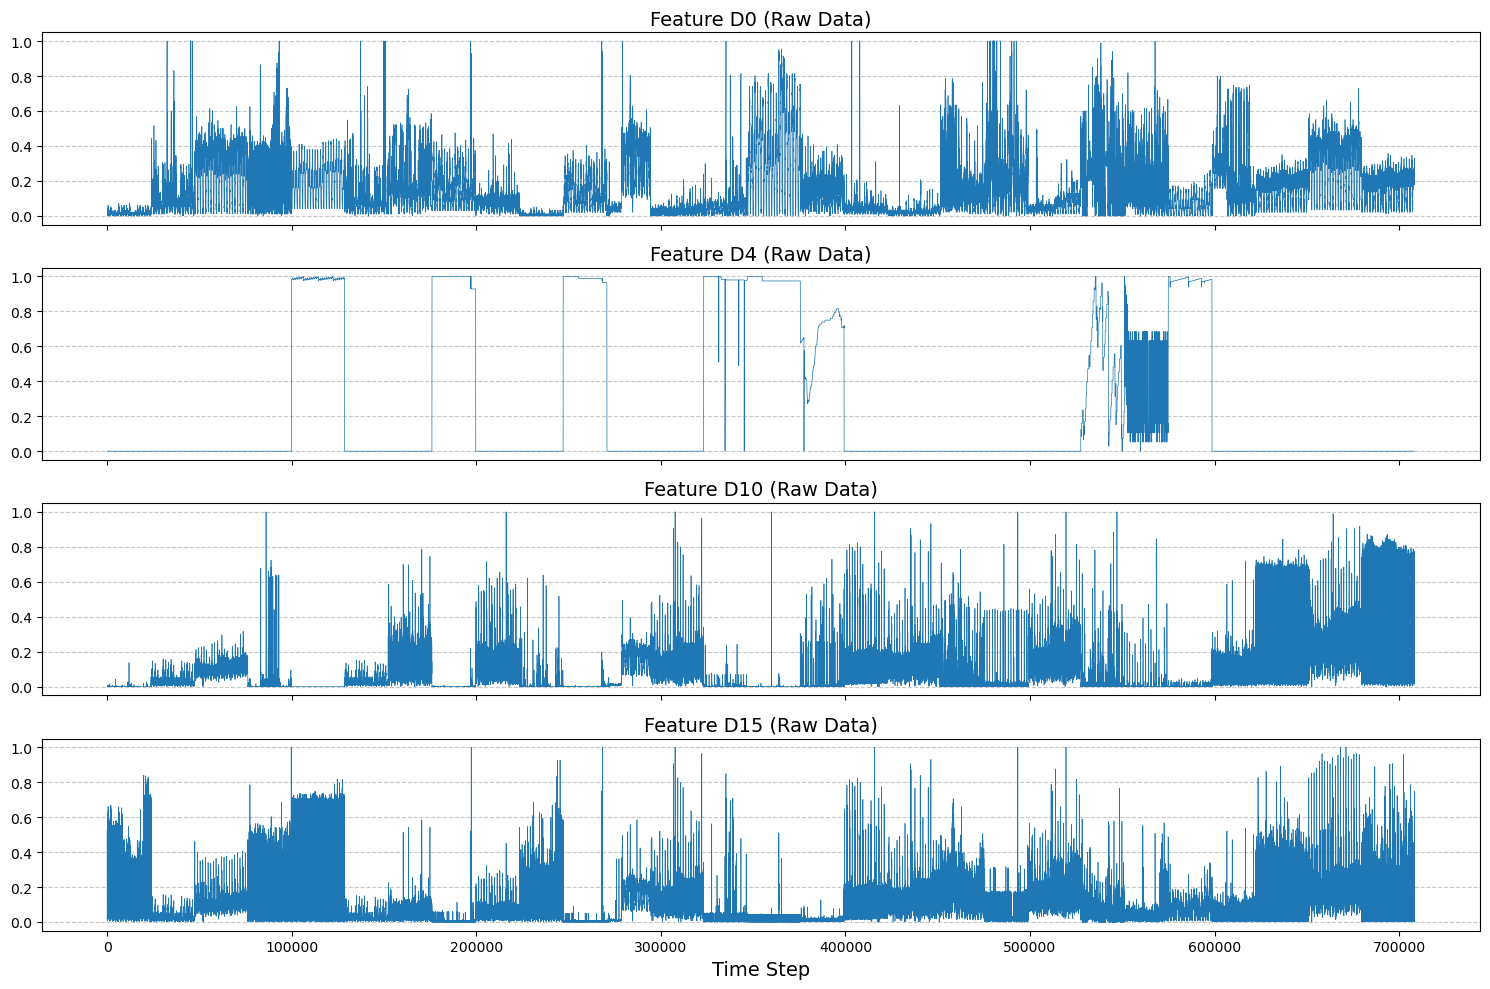

In [7]:
feature_indices = [0,4,10,15]  # Example feature indices to plot
features_to_plot = X_train_raw[:, feature_indices]
time_index = np.arange(T_train)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i, feature_index in enumerate(feature_indices):
    ax = axes[i] 
    ax.plot(
        time_index, 
        features_to_plot[:, i], 
        label=f'Feature D{feature_index}', 
        linewidth=0.5
    )
    # Set title, labels, and grid
    ax.set_title(f'Feature D{feature_index} (Raw Data)', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[3].set_xlabel('Time Step', fontsize=14)
plt.tight_layout()
plt.show()

Plotting the anomaly occurences

/var/folders/lc/6tn5hzlx0tqgcqc8_wc19qn40000gp/T/ipykernel_45927/1927323803.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=12)


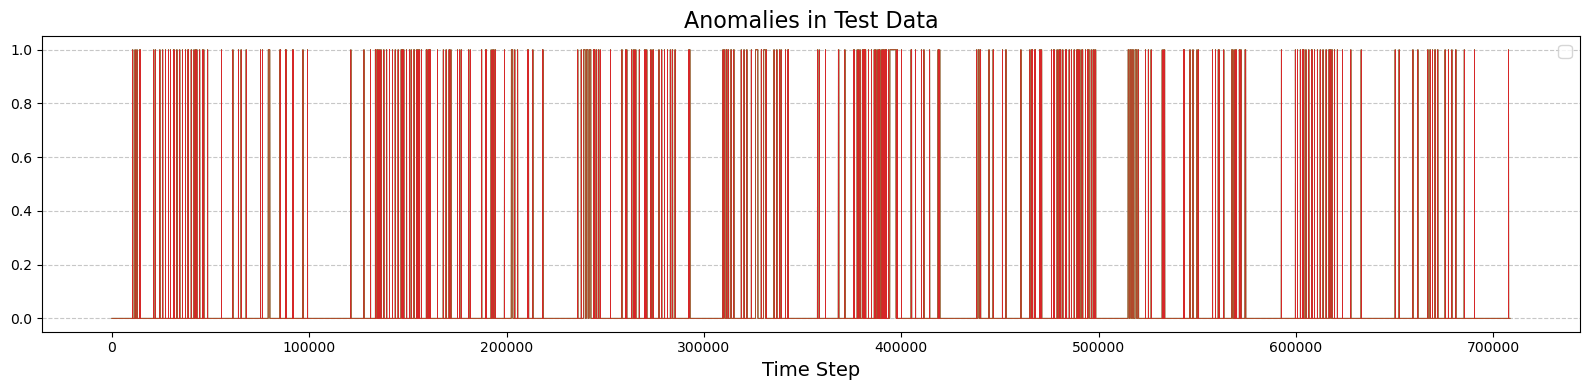

proportion of anomalies: 0.0416 in test set


In [8]:
plt.figure(figsize=(16, 4))
time_index = np.arange(T_test)
# Iterate through the selected features and plot them
for i, feature_index in enumerate(feature_indices):
    plt.plot(
        time_index, 
        y_test_raw,
        linewidth=0.5
    )

plt.title(f'Anomalies in Test Data', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"proportion of anomalies: {np.mean(y_test_raw):.4f} in test set")

### Basic statistics

In [15]:
check_nan_inf(X_train_raw, "X_train_raw")
check_nan_inf(X_test_raw, "X_test_raw")
check_nan_inf(y_test_raw, "y_test_raw")

print("\n--- Basic Statistics for X_train_raw ---")
basic_statistics(X_train_raw)

print("\n--- Basic Statistics for X_test_raw ---")
basic_statistics(X_test_raw)

print("\n--- Basic Statistics for y_test_raw ---")
stat_labels(y_test_raw)

X_train_raw contains no NaN or Inf values.
X_test_raw contains no NaN or Inf values.
y_test_raw contains no NaN or Inf values.

--- Basic Statistics for X_train_raw ---
Length : 708405
Num of sensors (features): 38
Number of continuous features: 37
Number of discrete features: 1
Discrete feature value distributions:
    Values: [0.0] -> Count: 1 feature(s)
    Repartition of discrete feature values: value 0 : 708405 (100.00 %), value 1 : 0 (0.00 %)

--- Basic Statistics for X_test_raw ---
Length : 708420
Num of sensors (features): 38
Number of continuous features: 37
Number of discrete features: 1
Discrete feature value distributions:
    Values: [0.0] -> Count: 1 feature(s)
    Repartition of discrete feature values: value 0 : 708420 (100.00 %), value 1 : 0 (0.00 %)

--- Basic Statistics for y_test_raw ---
Total number of points: 708420
Number of normal points: 678976.0 (95.84 %)
Number of anomalous points: 29444.0 (4.16 %)
Number of isolated anomalies (length = 1): 0
Number of anomal

### Further analisis for stationarity, noise check

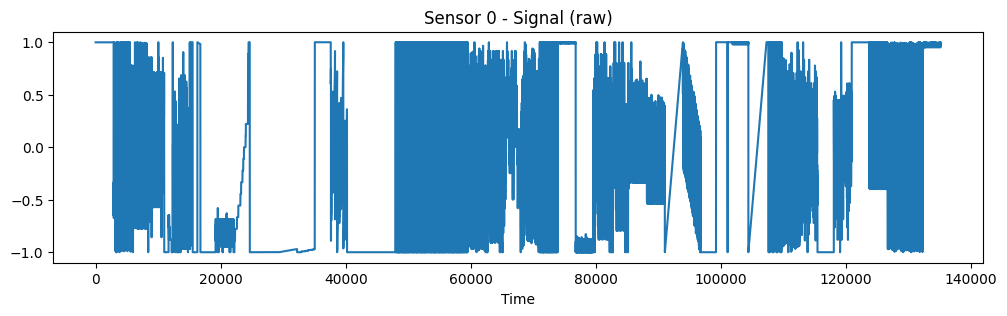

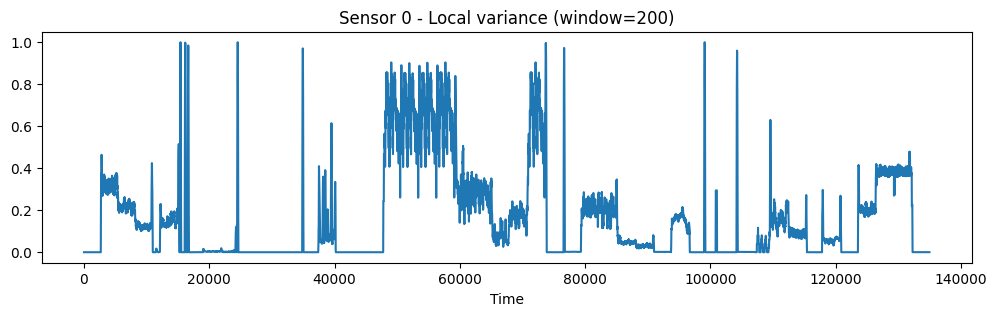

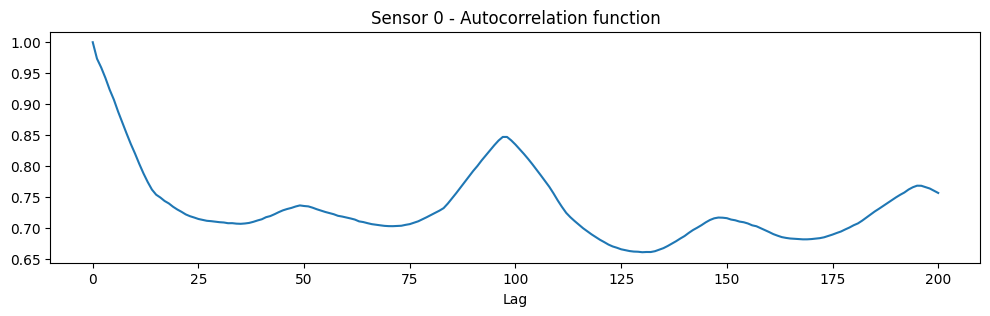

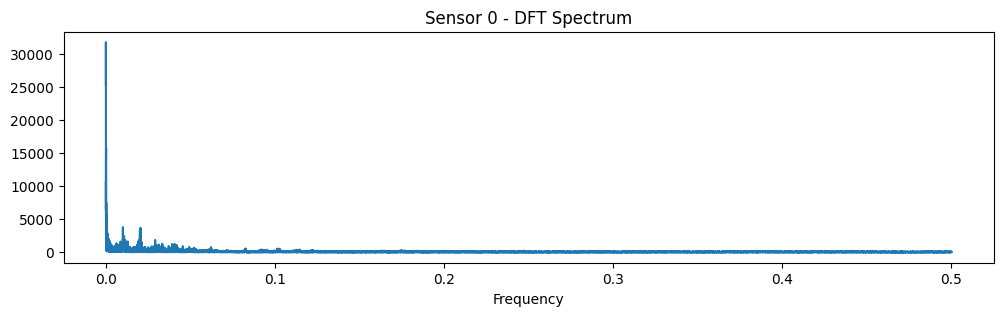

In [ ]:
sensor_id = 16 # We choose the sensor we want to analyze
data_analyze(X_train_raw[:, sensor_id], sensor_id=sensor_id)

### Detrending experimentation

In [ ]:
sensor_id = 0   # sensor 0 

# TRAIN
x0_train = X_train_raw[:, sensor_id]
x0_train_detrended, trend_train = detrend_least_squares(x0_train, order=2)

# TEST
x0_test = X_test_raw[:, sensor_id]
x0_test_detrended, trend_test = detrend_least_squares(x0_test, order=2)

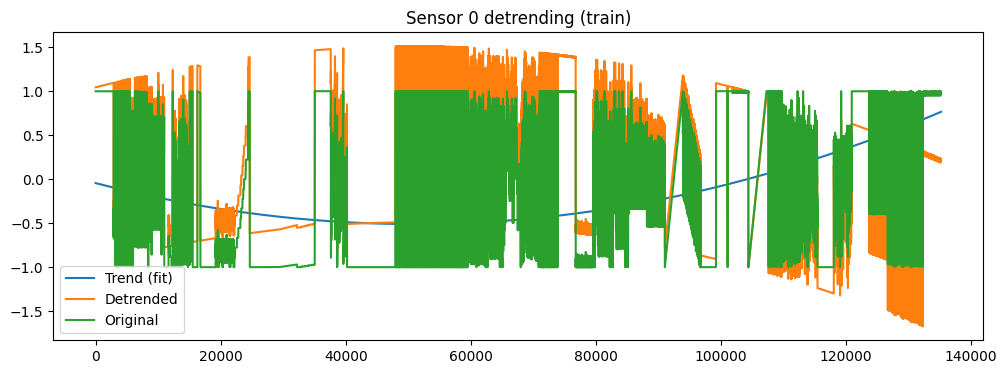

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(trend_train, label="Trend (fit)")
plt.plot(x0_train_detrended, label="Detrended")
plt.plot(x0_train, label="Original")
plt.legend()
plt.title("Sensor 0 detrending (train)")
plt.show()

## Baselines

### VAR(100)

In [ ]:
# -----------------------------
# 1) Fit a multivariate VAR(100)
# -----------------------------

val_ratio = 0.2
X_train, X_val = X_train_raw[:int((1 - val_ratio) * T_train)], X_train_raw[int((1 - val_ratio) * T_train):]
X_test = X_test_raw.copy()
labels_test = y_test_raw.copy()

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)
print("Label Test shape:", labels_test.shape)

# Fit VAR on training data
p = 100  # VAR order
print(f"\nFitting VAR({p}) on all {X_train.shape[1]} sensors...")
var_model = VAR(X_train)
var_results = var_model.fit(maxlags=p, ic=None, trend='c')  # fixed lag order
try:
    print(var_results.summary())
except np.linalg.LinAlgError:
    print("Warning: covariance not positive definite, skipping textual summary.")
# Effective order used (should be p)
print("VAR lag order used (k_ar):", var_results.k_ar)

# -----------------------------------------
# 2) One-step-ahead rolling forecast on test
# -----------------------------------------

T_test, _ = X_test.shape
k_ar = var_results.k_ar  # should be 100
print(f"k_ar: {k_ar}")

# Prediction on val
history_val = list(X_val[:k_ar])  # list of length k_ar of vectors (D_features,)
val_pred = []  # will store one-step-ahead predictions for the val set
for t in range(X_val.shape[0]-k_ar):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history_val[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    val_pred.append(y_hat)
    
    # Update history with the *true* val point at time t
    history_val.append(X_val[k_ar+t])
val_pred = np.array(val_pred) # shape (T_val-k_ar, D_features)
val_true = X_val[k_ar:]  # true values from time k_ar to T_val-1

# Prediction on test
history = list(X_test[:k_ar])  # list of length k_ar of vectors (D_features,)
test_pred = []  # will store one-step-ahead predictions for the test set
for t in range(T_test-k_ar):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    test_pred.append(y_hat)
    
    # Update history with the *true* test point at time t
    history.append(X_test[k_ar+t])

test_pred = np.array(test_pred) # shape (T_test-k_ar, D_features)
test_true = X_test[k_ar:]  # true values from time k_ar to T_test-1
labels_true = labels_test[k_ar:]  # true labels from time k_ar to T_test-1

print("\nForecast shapes:")
print("val_pred:", val_pred.shape)
print("val_true:", val_true.shape)
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# 3) Compute errors and anomaly scores
# --------------------------------------

val_scores, val_err, val_a = compute_normalized_scores(val_pred, val_true, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(test_pred, test_true, smooth_window=3)

In [ ]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_true, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


### AR(100)

In [ ]:
# -----------------------------
# 1) Paramètres
# -----------------------------
sensor_idx = 0           # on ne travaille que sur le sensor 0
p = 100          # ordre du modèle AR, ex. 100

val_ratio = 0.2
X_train, X_val = X_train_raw[:int((1 - val_ratio) * T_train),sensor_idx], X_train_raw[int((1 - val_ratio) * T_train):,sensor_idx]
X_test = X_test_raw[:, sensor_idx].copy()
labels_test = y_test_raw.copy()

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)
print("Label Test shape:", labels_test.shape)

# -----------------------------
# Fit AR(p) sur le train
# -----------------------------
ar_model = AutoReg(X_train, lags=p, old_names=False).fit()
print(ar_model.summary())

# Coefficients : x_t = const + sum_{k=1}^p phi_k * x_{t-k}
const = ar_model.params[0]
phi   = ar_model.params[1:]   # shape (p,)

print("AR order       :", len(phi))
print("Const          :", const)

# Prédiction sur le jeu de validation
history_val = list(X_val[:p])
val_pred = []
for t in range(X_val.shape[0]-p):
    past = np.array(history_val[-p:])   # shape (p,)
    lags = past[::-1]    # [x_{t-1}, ..., x_{t-p}]
    y_hat = const + np.dot(phi, lags)

    val_pred.append(y_hat)
    history_val.append(X_val[p+t])
    
val_pred = np.array(val_pred)
val_true = X_val[p:]

# Prédiction sur le jeu de test
history = list(X_test[:p])
test_pred = []
for t in range(T_test-p):
    past = np.array(history[-p:])   # shape (p,)
    lags = past[::-1]    # [x_{t-1}, ..., x_{t-p}]
    y_hat = const + np.dot(phi, lags)

    test_pred.append(y_hat)
    history.append(X_test[p+t])

test_pred = np.array(test_pred)
test_true = X_test[p:]
labels_true = labels_test[p:]

print("\nForecast shapes:")
print("val_pred:", val_pred.shape)
print("val_true:", val_true.shape)
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# Compute errors and anomaly scores
# --------------------------------------
# Absolute error per sensor ( PAS DE NORMALISATION ??)
val_scores, val_err, val_a = compute_normalized_scores(val_pred, val_true, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(test_pred, test_true, smooth_window=3)

In [ ]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_true, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_true, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Experiment #1 : Basic replication

In [ ]:
# Experiment configuration
config = {
    'window_size':5,
    'prediction_horizon':1,
    'val_ratio':0.2,
    'seed': 42,
    'batch_size':64,
    'embedding_dim':64,
    'decay': 0,
    'epoch': 50,
    'early_stop_win': 10,
    'beta': (0.9, 0.999)
}
config['save_path'] = "./model_normal/gdn_smap_w_"+str(config['window_size'])+"_epoch"+str(config['epoch'])+".pth"

In [ ]:
# Split training data into training and validation sets
X_train, X_val = np.split(X_train_raw, [int((1 - config['val_ratio']) * len(X_train_raw))])

# --- Sliding Window Creation ---
X_train_windows = create_sliding_windows(X_train, config['window_size'])
y_train_windows = X_train[config['window_size']:, :]
X_val_windows = create_sliding_windows(X_val, config['window_size'])
y_val_windows = X_val[config['window_size']:, :]
X_test_windows = create_sliding_windows(X_test_raw, config['window_size'])
y_test_windows = X_test_raw[config['window_size']:, :]
labels_test_windows = y_test_raw[config['window_size']:]

# Shape inspection
print("--- Sliding Window Creation ---")
print(f"X_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_val_windows shape: {X_val_windows.shape}")
print(f"y_val_windows shape: {y_val_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"labels_test_windows shape: {labels_test_windows.shape}")

# --- DataLoader Creation ---
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)
X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)
X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
label_test_tensor = torch.from_numpy(labels_test_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")


--- Sliding Window Creation ---
X_train_windows shape: (108141, 25, 5)
y_train_windows shape: (108141, 25)
X_val_windows shape: (27032, 25, 5)
y_val_windows shape: (27032, 25)
X_test_windows shape: (427612, 25, 5)
y_test_windows shape: (427612, 25)
labels_test_windows shape: (427612,)

--- DataLoader Creation Complete ---
Number of training batches: 3380
Number of validation batches: 845
Number of testing batches: 13363
Data is ready for the GDN model training.


### Training

In [ ]:
device = get_device()

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters
model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=D_features,
    dim=config['embedding_dim'],                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=config.get('out_layer_inter_dim', 64), # | original GDN: 64 or 128
    input_dim=config['window_size'],    # temporal window size | original GDN: 5
    out_layer_num=config.get('out_layer_num', 1),  # number of MLP layers in output layer | original GDN: 1
    topk=config.get('topk', 15)             # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)



edge_index shape: torch.Size([2, 600])


In [ ]:
train_losses = train(
    model=model,
    save_path=config['save_path'],
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader
)
print("Training finished. Best model saved to:", config['save_path'])

epoch (1 / 50) (Loss:0.01878693, ACU_loss:31.74991115)
epoch (2 / 50) (Loss:0.01369202, ACU_loss:23.13951914)
epoch (3 / 50) (Loss:0.01315616, ACU_loss:22.23391619)
epoch (4 / 50) (Loss:0.01286634, ACU_loss:21.74410617)
epoch (5 / 50) (Loss:0.01266912, ACU_loss:21.41081299)
epoch (6 / 50) (Loss:0.01256085, ACU_loss:21.22783270)
epoch (7 / 50) (Loss:0.01243776, ACU_loss:21.01981584)
epoch (8 / 50) (Loss:0.01233232, ACU_loss:20.84162105)
epoch (9 / 50) (Loss:0.01229394, ACU_loss:20.77675728)
epoch (10 / 50) (Loss:0.01218851, ACU_loss:20.59857673)
epoch (11 / 50) (Loss:0.01212970, ACU_loss:20.49919270)
epoch (12 / 50) (Loss:0.01209799, ACU_loss:20.44560550)
epoch (13 / 50) (Loss:0.01206206, ACU_loss:20.38487598)
epoch (14 / 50) (Loss:0.01203516, ACU_loss:20.33942537)
epoch (15 / 50) (Loss:0.01201668, ACU_loss:20.30818618)
epoch (16 / 50) (Loss:0.01199862, ACU_loss:20.27766409)
epoch (17 / 50) (Loss:0.01197795, ACU_loss:20.24273109)
epoch (18 / 50) (Loss:0.01194967, ACU_loss:20.19495075)
e

### Evaluation

In [ ]:
# If you want to load the best model later, uncomment the following line:
# model.load_state_dict(torch.load(config['save_path'], map_location=device))

# --- Evaluation on Validation and Test Sets ---
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

# Compute normalized anomaly scores
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

Validation Loss: 0.009338
Test Loss: 0.007966


In [ ]:
threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Experiments #2 : Anomaly in the train set

In [ ]:
# Configuration Parameters
config = {
    'seed': 42,
    'window_size': 5,
    'prediction_horizon': 1,
    'val_ratio': 0.2,
    'epoch': 50,
    'early_stop_win': 10,
    'batch_size': 32,
    'decay': 0,
    'beta': (0.9, 0.999),
    'emb_dim': 64,                 # embedding dimension | original GDN: 64 or 128
    'out_layer_inter_dim': 64,  # | original GDN: 64 or 128
    'out_layer_num': 1,          # number of layers in output MLP | original GDN: 1 or 2
    'topk': 15           # number of neighbors to keep in learned graph
}
config['save_path'] = "./model_normal/gdn_smap"+str(config['epoch'])+".pth"

### Data pre-processing

In [ ]:
# Split training data into training and validation sets
X_train, X_test = np.split(X_test_raw, [int(0.33 * len(X_test_raw))])
lambda_test = y_test_raw[int(0.33 * len(y_test_raw)):]
X_train, X_val = np.split(X_train, [int((1 - config['val_ratio']) * len(X_train))])

# --- Sliding Window Creation ---
X_train_windows = create_sliding_windows(X_train, config['window_size'])
y_train_windows = X_train[config['window_size']:, :]
X_val_windows = create_sliding_windows(X_val, config['window_size'])
y_val_windows = X_val[config['window_size']:, :]
X_test_windows = create_sliding_windows(X_test, config['window_size'])
y_test_windows = X_test[config['window_size']:, :]
labels_test_windows = lambda_test[config['window_size']:]

# Shape inspection
print("--- Sliding Window Creation ---")
print(f"X_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_val_windows shape: {X_val_windows.shape}")
print(f"y_val_windows shape: {y_val_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"labels_test_windows shape: {labels_test_windows.shape}")

# --- DataLoader Creation ---
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)
X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)
X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
label_test_tensor = torch.from_numpy(labels_test_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")

--- Sliding Window Creation ---
X_train_windows shape: (112885, 25, 5)
y_train_windows shape: (112885, 25)
X_val_windows shape: (28218, 25, 5)
y_val_windows shape: (28218, 25)
X_test_windows shape: (286499, 25, 5)
y_test_windows shape: (286499, 25)
labels_test_windows shape: (286499,)

--- DataLoader Creation Complete ---
Number of training batches: 3528
Number of validation batches: 882
Number of testing batches: 8954
Data is ready for the GDN model training.


### Training

In [ ]:
device = get_device()

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters
model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=D_features,
    dim=config['emb_dim'],                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=config['out_layer_inter_dim'], # | original GDN: 64 or 128
    input_dim=config['window_size'],    # temporal window size | original GDN: 5
    out_layer_num=config['out_layer_num'],
    topk=config['topk']               # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)

edge_index shape: torch.Size([2, 600])


In [ ]:
train_losses = train(
    model=model,
    save_path=config['save_path'],
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader
)

print("Training finished. Best model saved to:", config['save_path'])

epoch (1 / 50) (Loss:0.01803017, ACU_loss:30.47098287)
epoch (2 / 50) (Loss:0.01409969, ACU_loss:23.82848359)
epoch (3 / 50) (Loss:0.01303221, ACU_loss:22.02444052)
epoch (4 / 50) (Loss:0.01250595, ACU_loss:21.13506191)
epoch (5 / 50) (Loss:0.01189087, ACU_loss:20.09556868)
epoch (6 / 50) (Loss:0.01165523, ACU_loss:19.69734485)
epoch (7 / 50) (Loss:0.01258677, ACU_loss:21.27164593)
epoch (8 / 50) (Loss:0.01225753, ACU_loss:20.71522350)
epoch (9 / 50) (Loss:0.01211570, ACU_loss:20.47553576)
epoch (10 / 50) (Loss:0.01198231, ACU_loss:20.25009648)
epoch (11 / 50) (Loss:0.01161842, ACU_loss:19.63513365)
epoch (12 / 50) (Loss:0.01178156, ACU_loss:19.91083773)
epoch (13 / 50) (Loss:0.01225998, ACU_loss:20.71936494)
epoch (14 / 50) (Loss:0.01204002, ACU_loss:20.34763990)
epoch (15 / 50) (Loss:0.01199171, ACU_loss:20.26599451)
epoch (16 / 50) (Loss:0.01196057, ACU_loss:20.21336111)
epoch (17 / 50) (Loss:0.01199139, ACU_loss:20.26544957)
epoch (18 / 50) (Loss:0.01200623, ACU_loss:20.29052137)
e

### Evaluation

In [ ]:
# If you want to load the best model later, uncomment the following line:
# model.load_state_dict(torch.load(config['save_path'], map_location=device))

# --- Evaluation on Validation and Test Sets ---
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

# Compute normalized anomaly scores
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

In [ ]:
## Threshold selection based on validation set

threshold = np.max(val_scores) # threshold for anomaly detection

# Strict point-wise evaluation
strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
print("\n=== Point-wise Evaluation ===")
print(f"Precision : {strict_metrics['precision']:.4f}")
print(f"Recall    : {strict_metrics['recall']:.4f}")
print(f"F1-score  : {strict_metrics['f1']:.4f}")
print(f"AUC       : {strict_metrics['auc']:.4f}")

# Soft sequence-wise evaluation
soft_metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, threshold)
print("\n=== Sequence-wise Evaluation ===")
print(f"Precision : {soft_metrics['precision']:.4f}")
print(f"Recall    : {soft_metrics['recall']:.4f}")
print(f"F1-score  : {soft_metrics['f1']:.4f}")
print(f"AUC       : {soft_metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [ ]:
## Find best threshold based on F1-score

best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Point-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection_on_sequences(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best F1 : Sequence-wise Evaluation ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Expermient #3 : Changing window size

In [ ]:
# Configuration Parameters
config = {
    'seed': 42,
    'prediction_horizon': 1,
    'val_ratio': 0.2,
    'epoch': 50,
    'early_stop_win': 10,
    'batch_size': 32,
    'decay': 0,
    'beta': (0.9, 0.999),
    'emb_dim': 64,                 # embedding dimension | original GDN: 64 or 128
    'out_layer_inter_dim': 64,  # | original GDN: 64 or 128
    'out_layer_num': 1,          # number of layers in output MLP | original GDN: 1 or 2
    'topk': 15           # number of neighbors to keep in learned graph
}

window_list = [5, 10, 20, 50, 75, 100, 150, 200]

### Training

In [ ]:
device = get_device()

# Split training data into training and validation sets
X_train, X_val = np.split(X_train_raw, [int((1 - config['val_ratio']) * len(X_train_raw))])

# Create a fully connected undirected graph among features
nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

AUC_per_W = {}

for W in window_list:
    config['window_size'] = W
    config['save_path'] = "./model_normal/gdn_smap_w"+str(W)+"_epochs_"+str(config['epoch'])+".pth"
    
    # --- Sliding Window Creation ---
    X_train_windows = create_sliding_windows(X_train, config['window_size'])
    y_train_windows = X_train[config['window_size']:, :]
    X_val_windows = create_sliding_windows(X_val, config['window_size'])
    y_val_windows = X_val[config['window_size']:, :]
    X_test_windows = create_sliding_windows(X_test_raw, config['window_size'])
    y_test_windows = X_test_raw[config['window_size']:, :]
    labels_test_windows = y_test_raw[config['window_size']:]

    X_train_tensor = torch.from_numpy(X_train_windows)
    y_train_tensor = torch.from_numpy(y_train_windows)
    X_val_tensor = torch.from_numpy(X_val_windows)
    y_val_tensor = torch.from_numpy(y_val_windows)
    X_test_tensor = torch.from_numpy(X_test_windows)
    y_test_tensor = torch.from_numpy(y_test_windows)
    label_test_tensor = torch.from_numpy(labels_test_windows)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, label_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    model = GDN(
        edge_index_sets=edge_index_sets,
        node_num=D_features,
        dim=config['embedding_dim'],                 # embedding dimension | original GDN: 64 or 128
        out_layer_inter_dim=config.get('out_layer_inter_dim', 64), # | original GDN: 64 or 128
        input_dim=config['window_size'],    # temporal window size | original GDN: 5
        out_layer_num=config.get('out_layer_num', 1),  # number of MLP layers in output layer | original GDN: 1
        topk=config.get('topk', 15)             # number of neighbors to keep in learned graph | original GDN: 15 or 30
    ).to(device)
    train_losses = train(
        model=model,
        save_path=config['save_path'],
        config=config,
        train_dataloader=train_loader,
        val_dataloader=val_loader
    )
    print("Training finished. Best model saved to:", config['save_path'])
    
    # --- Evaluation on Validation and Test Sets ---
    val_loss, val_result = test(model, val_loader)
    test_loss, test_result = test(model, test_loader)
    print(f"Validation Loss: {val_loss:.6f}")
    print(f"Test Loss: {test_loss:.6f}")

    pred_val, gt_val = val_result
    pred_test, gt_test, labels_test = test_result

    pred_val = np.array(pred_val)
    gt_val = np.array(gt_val)
    pred_test = np.array(pred_test)
    gt_test = np.array(gt_test)
    labels_test = np.array(labels_test)

    # Compute normalized anomaly scores
    val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
    test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)
    threshold = np.max(val_scores) # threshold for anomaly detection

    # Strict point-wise evaluation
    strict_metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)
    AUC_per_W[W] = strict_metrics['auc']

### Plot

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(AUC_per_W.keys()), list(AUC_per_W.values()), marker='o', linewidth=2)
plt.xlabel("Window Size (w)", fontsize=12)
plt.ylabel("point-wise AUC", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(list(AUC_per_W.keys()))
plt.tight_layout()
plt.show()